In [5]:
# !pip install google-play-scraper
# !pip install tqdm

In [4]:
import json
import pandas as pd
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

import requests  # Add this line
from io import BytesIO


from pygments import highlight
from pygments.lexers import JsonLexer
from pygments.formatters import TerminalFormatter

from google_play_scraper import Sort, reviews, app

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

In [7]:
app_packages = [
  'com.anydo',
  'com.todoist',
  'com.ticktick.task',
  'com.habitrpg.android.habitica',
  'cc.forestapp',
  'com.oristats.habitbull',
  'com.levor.liferpgtasks',
  'com.habitnow',
  'com.microsoft.todos',
  'prox.lab.calclock',
  'com.gmail.jmartindev.timetune',
  'com.artfulagenda.app',
  'com.tasks.android',
  'com.appgenix.bizcal',
  'com.appxy.planner'
]

len(app_packages)

15

The `app_packages` contain list of packages we are interested in scraping .  We'll use `AppAnnie` to select some of the top US apps.

# Scrapping App Info

In [16]:
app_infos = []

for ap in tqdm(app_packages):
  info = app(ap, lang='en', country='us')
  del info['comments']
  app_infos.append(info)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:15<00:00,  1.04s/it]


### Helper Function to print the json better

In [17]:
def print_json(json_object):
  json_str = json.dumps(
    json_object,
    indent=2,
    sort_keys=True,
    default=str
  )
  print(highlight(json_str, JsonLexer(), TerminalFormatter()))

In [18]:
print_json(app_infos[0])

{
  "adSupported": false,
  "appId": "com.anydo",
  "categories": [
    {
      "id": "PRODUCTIVITY",
      "name": "Productivity"
    }
  ],
  "containsAds": false,
  "contentRating": "Everyone",
  "contentRatingDescription": null,
  "currency": "USD",
  "description": "\ud83e\udd47 <b>\"#1 to do list app out there\u201d</b> - WSJ\r\n\ud83c\udfc6 <b>Editor's Choice</b> by Google\r\n\r\nOver 40M people rely on Any.do to stay organized and get more done.\r\nIt's a simple to do list app with reminders, a planner & calendar - all in one.\r\n\r\n<b>\ud83e\udd47 \"A MUST HAVE APP\" (Lifehacker, NYTimes, USA TODAY).</b>\r\n\r\nAny.do is a free to-do list, planner & calendar app for managing and organizing your daily tasks, to-do lists, notes, reminders, checklists, calendar events, grocery lists, and more.\r\n\r\nOrganize your tasks & to-do list\r\n\r\n\u2022 ADVANCED CALENDAR & DAILY PLANNER - Keep your to-do list and calendar events always at hand with our calendar widget. Any.do to-do lis

In [19]:
app_infos[0]["icon"]

'https://play-lh.googleusercontent.com/rmzeq_sIQ0Ajs1R0Dx1FhZevoTgnWfY_enZ1AOkBRdhAjnwFqekzw-o-B2rTRyO0XA'

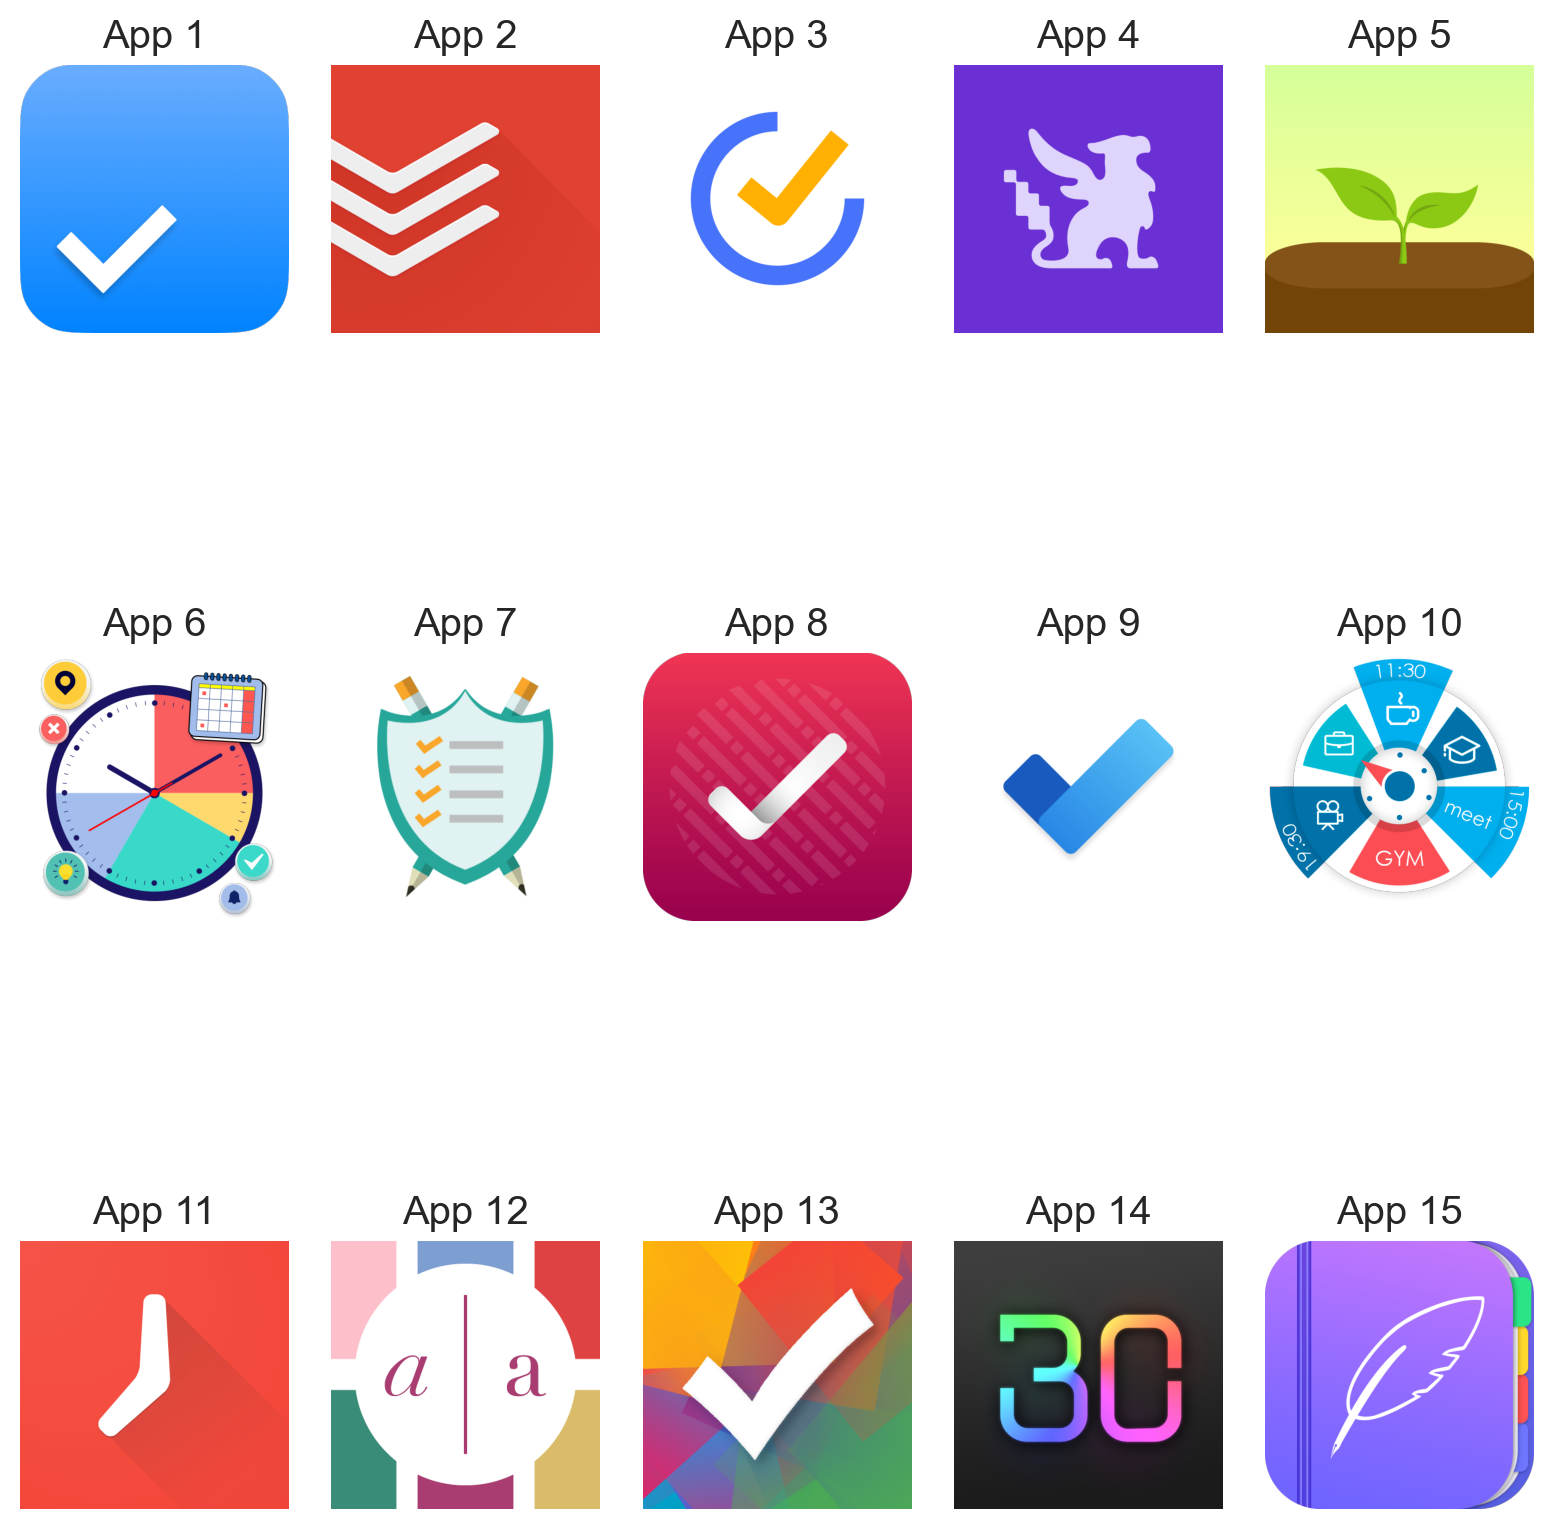

In [21]:
# Define the size of the grid
num_rows = 3
num_cols = 5
total_apps = num_rows * num_cols

# Create a figure and axis objects
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 10))

# Flatten the axes for easy iteration
axes = axes.flatten()

# Plot each app's icon
for i in range(total_apps):
    icon_path = app_infos[i]["icon"]
    ax = axes[i]
    ax.axis('off')  # Turn off axis
    ax.set_title(f'App {i+1}')
    
    if icon_path.startswith('http'):
        try:
            response = requests.get(icon_path)
            img = Image.open(BytesIO(response.content))
            ax.imshow(img)
        except Exception as e:
            ax.text(0.5, 0.5, f'Error: {str(e)}', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        try:
            img = Image.open(icon_path)
            ax.imshow(img)
        except FileNotFoundError:
            ax.text(0.5, 0.5, 'Image Not Found', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

# Adjust layout
plt.tight_layout()
plt.show()

Above are the apps that we scrapped and we will test sentiment of 

In [21]:
app_infos = pd.DataFrame(app_infos)
app_infos.to_csv('apps.csv')

# Getting App Reviews

In [9]:
app_reviews_list = []

for app_name in tqdm(app_packages):
    app_reviews_df = pd.DataFrame()  # Create an empty DataFrame for each app
    
    for score in range(1, 6):
        for sort_order in [Sort.MOST_RELEVANT, Sort.NEWEST]:
            # Fetch reviews for the current app, score, and sort order
            fetched_reviews, _ = reviews(
                app_name,
                lang='en',
                country='us',
                sort=sort_order,
                count=200 if score == 3 else 100,
                filter_score_with=score
            )
            
            # Add additional columns
            for review in fetched_reviews:
                review['sortOrder'] = 'most_relevant' if sort_order == Sort.MOST_RELEVANT else 'newest'
                review['appId'] = app_name
            
            # Convert the reviews to a DataFrame
            reviews_df = pd.DataFrame(fetched_reviews)
            
            # Concatenate the reviews DataFrame to the app's DataFrame
            app_reviews_df = pd.concat([app_reviews_df, reviews_df], ignore_index=True)
    
    # Append the app's DataFrame to the list
    app_reviews_list.append(app_reviews_df)

 13%|██████████████████████▉                                                                                                                                                     | 2/15 [00:21<02:20, 10.80s/it]C:\Users\KIIT\AppData\Local\Temp\ipykernel_5008\310086500.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  app_reviews_df = pd.concat([app_reviews_df, reviews_df], ignore_index=True)
 53%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                                | 8/15 [01:22<01:07,  9.70s/it]C:\Users\KIIT\AppData\Local\Temp\ipykernel_5008\310086500.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entrie

In [10]:
len(app_reviews_list)

15

In [12]:
len(app_reviews_list[1])

1198

### Store the Reviews using Pickle

In [13]:
import pickle

In [15]:
with open('app_reviews_list.pkl', 'wb') as f:
    pickle.dump(app_reviews_list, f)